# Binary Classification with Radiomics, CNNs, and Contrastive Learning for Pathology Images
Overview

In this assignment, you will develop models for a binary image classification task, moving from traditional hand-crafted features to deep learning and contrastive self-supervised learning.
You will implement, train, and evaluate models at each stage, and reflect on their performance.

We will explore three approaches:

    Radiomics + Random Forest: Extract simple image features and train a traditional machine learning classifier.

    Simple CNN: Build and train a small convolutional neural network from scratch.

    Contrastive Learning + Fine-Tuning: Pretrain using SimCLR-style contrastive learning and fine-tune the model for classification.

Learning Objectives

By completing this assignment, you will:

    Understand how to extract basic radiomics features from images

    Train and evaluate a Random Forest classifier

    Build a custom CNN for binary classification

    Apply contrastive learning for representation learning

    Interpret model performance using metrics like ROC AUC, precision, recall, and F1-score

    Visualize feature spaces using PCA

Tasks

You are expected to:

    Task 1: Extract three radiomic features (mean intensity, standard deviation, blur score) and train a Random Forest model. Evaluate using precision, recall, F1-score, ROC AUC, and confidence intervals.

    Task 2: Implement a small 3-layer CNN and train it on the binary classification dataset. Analyze its performance.

    Task 3: Pretrain a model using a SimCLR-style contrastive learning framework. Fine-tune it for the binary classification task and compare performance to the CNN trained from scratch.

# 1. Setup

In [ ]:
# ========================================
# 1. Install and load libraries
# ========================================
!pip install -q medmnist timm torchvision scikit-learn matplotlib pyradiomics

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import timm
from medmnist import PathMNIST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import torch
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [ ]:
# ========================================
# 2. Prepare Dataset
# ========================================

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from medmnist import PathMNIST

print("Loading PathMNIST...")

# Load dataset with ToTensor() transform
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)
test_dataset = PathMNIST(split='test', transform=transform, download=True)

# Binary dataset creation
class BinaryCancerDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        label = int(label)
        new_label = 1 if label == 8 else 0
        return img, new_label

print("Preparing binary datasets...")

# Create datasets
binary_train = BinaryCancerDataset(train_dataset)
binary_val = BinaryCancerDataset(val_dataset)
binary_test = BinaryCancerDataset(test_dataset)

# DataLoaders
train_loader = DataLoader(binary_train, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(binary_val, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(binary_test, batch_size=64, shuffle=False, num_workers=0)

print("Datasets and loaders ready.")


Loading PathMNIST...


100%|██████████| 206M/206M [02:24<00:00, 1.42MB/s]


Preparing binary datasets...
Datasets and loaders ready.


# 2. Radiomics Model
In this section, we explore whether simple, hand-crafted radiomic features can distinguish between cancerous and non-cancerous tissue patches.

We extract three basic features from each image:

    - Mean pixel intensity: average brightness of the patch,

    - Standard deviation of intensity: variability in pixel values,

    - Blur score: image sharpness estimated using Laplacian variance.

These features are then used to train a Random Forest classifier to predict binary cancer labels.

We evaluate the model using:

    - Precision, Recall, and F1-score,

    - ROC AUC score,

    - Bootstrap resampling (1000 iterations) to compute a 95% confidence interval for the ROC AUC, ensuring robust statistical assessment.

Finally, we use Principal Component Analysis (PCA) to reduce the radiomic feature space to two dimensions and visualize how well the cancer vs non-cancer samples separate based on these basic features.

<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)



 Random Forest Results (Radiomics Features):
              precision    recall  f1-score   support

           0     0.9098    0.9669    0.9375      5947
           1     0.7709    0.5377    0.6335      1233

    accuracy                         0.8932      7180
   macro avg     0.8404    0.7523    0.7855      7180
weighted avg     0.8860    0.8932    0.8853      7180

ROC AUC: 0.9259
Precision: 0.7709
Recall: 0.5377
F1 Score: 0.6335
ROC AUC 95% CI: [0.9175, 0.9335]


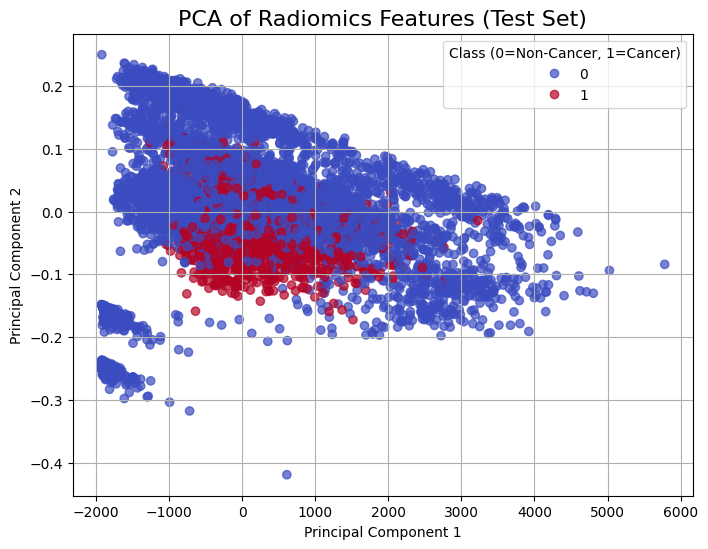

In [ ]:
# ========================================
# 3. Radiomics + Random Forest (Enhanced)
# ========================================
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Feature extraction
def extract_basic_features(imgs):
    features = []
    for img in imgs:
        img_np = img.numpy().transpose(1,2,0)[:,:,0]  # Take first channel
        mean_intensity = img_np.mean()
        std_intensity = img_np.std()
        blur_score = cv2.Laplacian((img_np*255).astype(np.uint8), cv2.CV_64F).var()
        features.append([mean_intensity, std_intensity, blur_score])
    return np.array(features)

# Extract features
X_train = extract_basic_features([binary_train[i][0] for i in range(len(binary_train))])
y_train = [binary_train[i][1] for i in range(len(binary_train))]

X_test = extract_basic_features([binary_test[i][0] for i in range(len(binary_test))])
y_test = [binary_test[i][1] for i in range(len(binary_test))]

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:,1]


# Evaluation Metrics
print("\n Random Forest Results (Radiomics Features):")
print(classification_report(y_test, rf_preds, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, rf_probs):.4f}")
print(f"Precision: {precision_score(y_test, rf_preds):.4f}")
print(f"Recall: {recall_score(y_test, rf_preds):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_preds):.4f}")

# Bootstrap Confidence Intervals (95%)
n_iterations = 1000
auc_scores = []
for i in range(n_iterations):
    indices = resample(np.arange(len(y_test)), random_state=i)
    if len(np.unique([y_test[idx] for idx in indices])) < 2:
        continue  # Skip if resampled set lacks both classes
    score = roc_auc_score([y_test[idx] for idx in indices], [rf_probs[idx] for idx in indices])
    auc_scores.append(score)

ci_lower = np.percentile(auc_scores, 2.5)
ci_upper = np.percentile(auc_scores, 97.5)
print(f"ROC AUC 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ========================================
# PCA Visualization
# ========================================
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.title('PCA of Radiomics Features (Test Set)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Non-Cancer, 1=Cancer)")
plt.grid(True)
plt.show()


# 3. Simple-CNN Classifier

<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


Epoch 1/5 | Loss: 0.3258
Epoch 2/5 | Loss: 0.1774
Epoch 3/5 | Loss: 0.1495
Epoch 4/5 | Loss: 0.1319
Epoch 5/5 | Loss: 0.1229

📈 Small 3-Layer CNN Results (CPU Training):
              precision    recall  f1-score   support

           0     0.9036    0.9864    0.9432      5947
           1     0.8823    0.4923    0.6320      1233

    accuracy                         0.9015      7180
   macro avg     0.8929    0.7393    0.7876      7180
weighted avg     0.8999    0.9015    0.8897      7180

ROC AUC: 0.7393
Precision: 0.8823
Recall: 0.4923
F1 Score: 0.6320


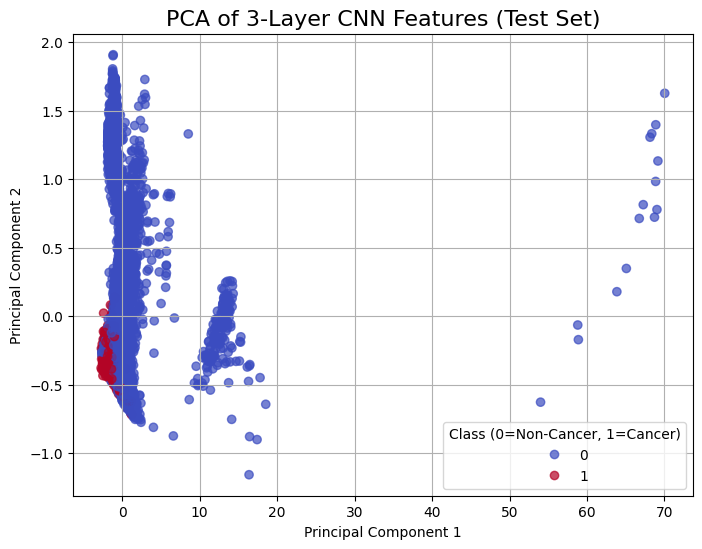

In [ ]:
# ========================================
# 4. Small 3-Layer CNN Classifier
# ========================================

train_loader = DataLoader(binary_train, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(binary_val, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(binary_test, batch_size=64, shuffle=False, num_workers=0)

# Define a simple 3-layer CNN
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (B,32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,32,14,14)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (B,64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B,64,7,7)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (B,128,7,7)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # (B,128,1,1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)  # Binary classification (cancer vs non-cancer)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(device)

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train function
def train_model(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f}")

# Train
train_model(model, train_loader, optimizer, criterion, epochs=5)

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels, all_features = [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            features = model.features(imgs)
            outputs = model.classifier(features)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_features.append(features.view(features.size(0), -1).cpu().numpy())

    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.vstack(all_features))

# Evaluate
y_true, y_pred, test_features = evaluate_model(model, test_loader)

# Metrics
print("\n📈 Small 3-Layer CNN Results:")
print(classification_report(y_true, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

# PCA Visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=y_true, cmap='coolwarm', alpha=0.7)
plt.title('PCA of 3-Layer CNN Features (Test Set)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Non-Cancer, 1=Cancer)")
plt.grid(True)


# 4. Contastive Learning Example

Starting SimCLR-style Contrastive Pretraining with SimpleCNN...


<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


Contrastive Epoch 1/5 - Average Loss: 4.8022
Contrastive Epoch 2/5 - Average Loss: 4.7142
Contrastive Epoch 3/5 - Average Loss: 4.6936
Contrastive Epoch 4/5 - Average Loss: 4.6804
Contrastive Epoch 5/5 - Average Loss: 4.6722
Contrastive Pretraining Complete.
Extracting Features for PCA Visualization...
Running PCA...


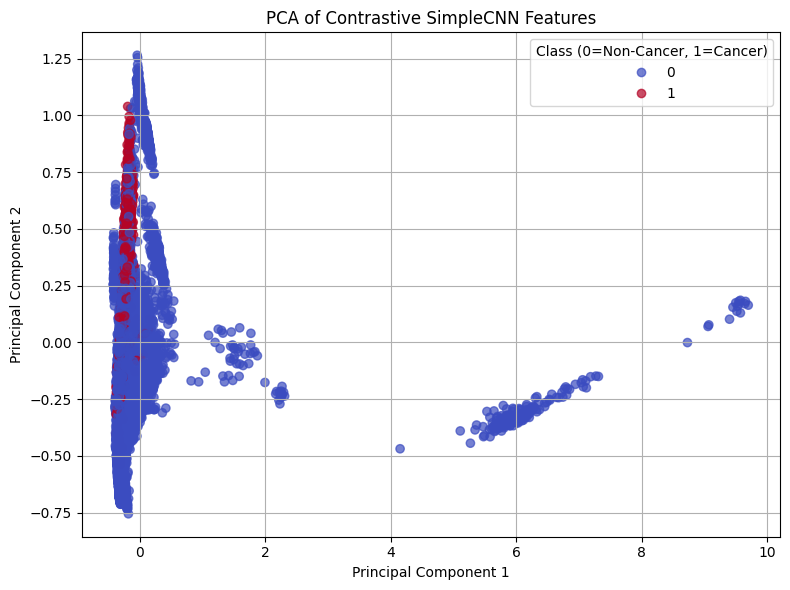

Starting Downstream Classification Fine-Tuning...


<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


Downstream Epoch 1/5 - Average Loss: 0.3333
Downstream Epoch 2/5 - Average Loss: 0.1781
Downstream Epoch 3/5 - Average Loss: 0.1496
Downstream Epoch 4/5 - Average Loss: 0.1362
Downstream Epoch 5/5 - Average Loss: 0.1298
Evaluating Fine-tuned Classifier...

Downstream Classifier Results:
              precision    recall  f1-score   support

           0     0.9476    0.9697    0.9585      5947
           1     0.8355    0.7413    0.7856      1233

    accuracy                         0.9305      7180
   macro avg     0.8915    0.8555    0.8720      7180
weighted avg     0.9283    0.9305    0.9288      7180

ROC AUC: 0.8555
Precision: 0.8355
Recall: 0.7413
F1 Score: 0.7856
Finished Fine-Tuning and Evaluation.


In [ ]:
# ========================================
# 6. SimCLR-style Contrastive Learning + PCA + Downstream Fine-Tuning (SimpleCNN Version)
# ========================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# 6.1 Contrastive Pretraining
print("Starting SimCLR-style Contrastive Pretraining with SimpleCNN...")

# Contrastive Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return self.transform(img), self.transform(img)

    def __len__(self):
        return len(self.dataset)

# Contrastive Transform
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(),
])

# Dataset and Loader
contrastive_train = ContrastiveDataset(binary_train, contrastive_transform)
contrastive_loader = DataLoader(contrastive_train, batch_size=128, shuffle=True, num_workers=0)

# Simple CNN Encoder
class SimpleCNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1))
        )
        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        features = self.features(x)
        projections = self.projector(features)
        return projections

encoder = SimpleCNNEncoder().to(device)
optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3)

# NT-Xent Loss
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)
    labels = torch.cat([torch.arange(z1.size(0)) for _ in range(2)], dim=0).to(device)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    mask = torch.eye(labels.size(0), device=device).bool()
    labels = labels[~mask].view(labels.size(0), -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.size(0), -1)
    positives = similarity_matrix[labels.bool()].view(similarity_matrix.size(0), -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.size(0), -1)
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)
    return F.cross_entropy(logits, labels)

# Pretraining
for epoch in range(5):
    encoder.train()
    running_loss = 0.0
    for img1, img2 in contrastive_loader:
        img1, img2 = img1.to(device), img2.to(device)
        z1, z2 = encoder(img1), encoder(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer_enc.zero_grad()
        loss.backward()
        optimizer_enc.step()
        running_loss += loss.item()
    print(f"Contrastive Epoch {epoch+1}/5 - Average Loss: {running_loss/len(contrastive_loader):.4f}")

print("Contrastive Pretraining Complete.")

# ========================================
# 6.2 PCA Visualization
# ========================================

print("Extracting Features for PCA Visualization...")

# Extract feature vectors
def extract_features(encoder, loader):
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feat = encoder.features(imgs)
            feat = F.adaptive_avg_pool2d(feat, (1, 1)).view(feat.size(0), -1)
            features.append(feat.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.concatenate(labels)

feature_loader = DataLoader(binary_test, batch_size=64, shuffle=False, num_workers=0)
test_features, test_labels = extract_features(encoder, feature_loader)

# PCA
print("Running PCA...")
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=test_labels, cmap='coolwarm', alpha=0.7)
plt.title('PCA of Contrastive SimpleCNN Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Non-Cancer, 1=Cancer)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 6.3 Downstream Fine-Tuning (Classification)
# ========================================

print("Starting Downstream Classification Fine-Tuning...")

# Simple downstream classifier
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.backbone = encoder.features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = self.classifier(x)
        return x

model_downstream = DownstreamClassifier(encoder).to(device)
optimizer_downstream = torch.optim.Adam(model_downstream.parameters(), lr=1e-4)
criterion_downstream = nn.CrossEntropyLoss()

# Training
def train_downstream(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Downstream Epoch {epoch+1}/5 - Average Loss: {running_loss/len(loader):.4f}")

# Evaluation
def evaluate_downstream(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# Fine-tune and evaluate
train_downstream(model_downstream, train_loader, optimizer_downstream, criterion_downstream, epochs=5)

print("Evaluating Fine-tuned Classifier...")
y_true, y_pred = evaluate_downstream(model_downstream, test_loader)

print("\nDownstream Classifier Results:")
print(classification_report(y_true, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")

print("Finished Fine-Tuning and Evaluation.")


# 5. Radiomics Exercise: Feature Expansion and Model Tuning

## In this exercise, you will build upon the basic radiomics model we developed earlier.

### Goal: Expand the radiomic features extracted from each image and optimize the Random Forest classifier using grid search.

Instructions:
Feature Engineering:
    Extend the current feature extraction function.
    In addition to mean intensity, standard deviation, and blur score, add at least three more features, such as:
     - Entropy: Measures randomness of pixel intensities
     - Skewness: Measures asymmetry of the intensity distribution
     - Kurtosis: Measures "peakedness" of the intensity distribution.

Class Imbalance:
      - Use class weights to account for the class imbalance

Model Tuning:
    Use GridSearchCV to tune Random Forest hyperparameters, such as:
      - n_estimators (number of trees)
      - max_depth (maximum depth of trees)
      - min_samples_split (minimum samples to split an internal node)

Model Evaluation:
    After finding the best model, evaluate its performance on the test set using:
      - ROC AUC
      - Precision
      - Recall
      - F1 Score

PCA Visualization:
    Plot the first two principal components of the extracted features to visually assess how well the two classes (cancer vs non-cancer) separate.

### Expected Outcomes:
Improved classifier performance compared to the basic radiomics model.
   - Better separation of cancer vs non-cancer samples in the PCA plot.
   - A deeper understanding of how radiomic features contribute to model performance.

### Challenge (Optional):

Try adding even more advanced features like:
        - Local binary patterns (LBP)
        - Haralick texture features (from Gray Level Co-occurrence Matrices, GLCMs)
        - Try alternive methods to account for the class imbalance

In [ ]:
# ========================================
# Student Exercise: Radiomics Feature Expansion + Handling Class Imbalance + Grid Search Random Forest
# ========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Step 1: Feature extraction
def extract_radiomics_features(imgs):
    features = []
    for img in imgs:
        img_np = img.numpy().transpose(1,2,0)[:,:,0]  # Take first channel

        mean_intensity = img_np.mean()
        std_intensity = img_np.std()
        blur_score = cv2.Laplacian((img_np*255).astype(np.uint8), cv2.CV_64F).var()

        # TODO: Add entropy
        # TODO: Add skewness
        # TODO: Add kurtosis

        features.append([mean_intensity, std_intensity, blur_score])
    return np.array(features)

# Step 2: Extract features
X_train = extract_radiomics_features([binary_train[i][0] for i in range(len(binary_train))])
y_train = np.array([binary_train[i][1] for i in range(len(binary_train))])

X_test = extract_radiomics_features([binary_test[i][0] for i in range(len(binary_test))])
y_test = np.array([binary_test[i][1] for i in range(len(binary_test))])

# Step 3: Handle class imbalance
# TODO: Compute class weights

# Step 4: Model selection with Grid Search
# TODO: Set up GridSearchCV with class_weight included

# Step 5: Train best model
# TODO: Fit best model on training data

# Step 6: Evaluate
# TODO: Predict on test data
# TODO: Print classification report, ROC AUC, Precision, Recall, F1 Score

# Step 7: PCA Visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.title('PCA of Extended Radiomics Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Non-Cancer, 1=Cancer)")
plt.grid(True)
plt.show()


<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)
<ipython-input-12-24515ba86280>:27: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = scipy.stats.skew(img_np.flatten())
<ipython-input-12-24515ba86280>:28: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(img_np.flatten())


Computed class weights: {0: np.float64(0.5835483912801027), 1: np.float64(3.4922778424524643)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Hyperparameters: {'class_weight': {0: np.float64(0.5835483912801027), 1: np.float64(3.4922778424524643)}, 'max_depth': 20, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0     0.9604    0.9590    0.9597      5947
           1     0.8035    0.8094    0.8065      1233

    accuracy                         0.9333      7180
   macro avg     0.8820    0.8842    0.8831      7180
weighted avg     0.9335    0.9333    0.9334      7180

ROC AUC: 0.8842
Precision: 0.8035
Recall: 0.8094
F1 Score: 0.8065


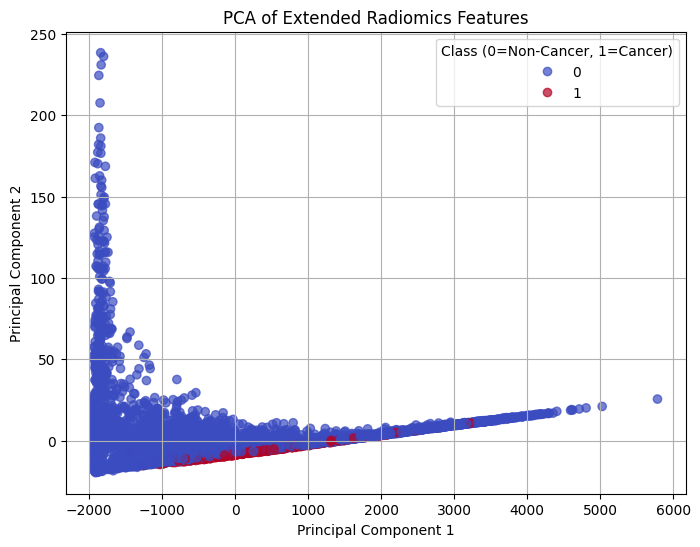

In [ ]:
# ========================================
# Radiomics Feature Expansion + Handling Class Imbalance + Grid Search Random Forest (Answers)
# ========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Step 1: Feature extraction
def extract_radiomics_features(imgs):
    features = []
    for img in imgs:
        img_np = img.numpy().transpose(1,2,0)[:,:,0]  # Take first channel

        mean_intensity = img_np.mean()
        std_intensity = img_np.std()
        blur_score = cv2.Laplacian((img_np*255).astype(np.uint8), cv2.CV_64F).var()

        # Extended features
        entropy = scipy.stats.entropy(np.histogram(img_np.flatten(), bins=256)[0] + 1)
        skewness = scipy.stats.skew(img_np.flatten())
        kurtosis = scipy.stats.kurtosis(img_np.flatten())

        features.append([mean_intensity, std_intensity, blur_score, entropy, skewness, kurtosis])
    return np.array(features)

# Step 2: Extract features
X_train = extract_radiomics_features([binary_train[i][0] for i in range(len(binary_train))])
y_train = np.array([binary_train[i][1] for i in range(len(binary_train))])

X_test = extract_radiomics_features([binary_test[i][0] for i in range(len(binary_test))])
y_test = np.array([binary_test[i][1] for i in range(len(binary_test))])

# Step 3: Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}
print(f"Computed class weights: {class_weight_dict}")

# Step 4: Model selection with Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': [class_weight_dict]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=3,
                           scoring='f1',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Step 5: Train best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Step 6: Evaluate
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Step 7: PCA Visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap='coolwarm', alpha=0.7)
plt.title('PCA of Extended Radiomics Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Non-Cancer, 1=Cancer)")
plt.grid(True)
plt.show()


# 6. SimpleCNN Exercise: Model Expansion and Tuning

In this exercise, you will work on improving a basic convolutional neural network (CNN) architecture and optimizing its training process.

Goal:
Expand the SimpleCNN model by adding layers such as Batch Normalization and Dropout, and improve its performance through better training strategies.

Instructions:

    Model Architecture:

        Add more convolutional layers to deepen the network.

        Add Batch Normalization after convolutions to stabilize learning.

        Add Dropout layers to prevent overfitting.

        Use an Adaptive Average Pooling layer before the final classifier.

    Training Strategy:

        Tune the optimizer and learning rate.

        Start with Adam optimizer (lr=1e-3 or lr=1e-4).

        Use CrossEntropyLoss for binary classification.

    Model Evaluation:

        After training, evaluate the model using:

            Precision

            Recall

            F1 Score

            ROC AUC

    Optional Challenge:

        Try using learning rate scheduling (e.g., StepLR, ReduceLROnPlateau).

        Try add in a technique to account for the class imbalance

        Tune the number of layers and dropout

        Change architecture to ResNet18, ViT

In [ ]:
# ========================================
# Student Exercise: Improve the SimpleCNN and Tune Hyperparameters
# ========================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# Step 1: Improve the model
# TODO: Expand SimpleCNN with more Conv layers, BatchNorm, and Dropout
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # TODO: Add more convolutional layers
            # TODO: Add BatchNorm layers
            # TODO: Add Dropout layers
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)

# Step 2: Set up Optimizer and Loss
# TODO: Try tuning learning rate and optimizer (Adam, SGD, etc.)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Modify if needed
criterion = nn.CrossEntropyLoss()

# Step 3: Train Function
def train_cnn(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {running_loss/len(loader):.4f}")

# Step 4: Evaluation Function
def evaluate_cnn(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# Step 5: Train the Model
# TODO: Train on train_loader

# Step 6: Evaluate the Model
# TODO: Evaluate on test_loader and print metrics

# Step 7: Challenge (Optional)
# TODO: Try using learning rate scheduling (ReduceLROnPlateau or StepLR)


In [ ]:
# ========================================
# Solution: Improved SimpleCNN + Hyperparameter Tuning
# ========================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# Step 1: Improved SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.3)  # Add dropout
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)

# Step 2: Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Lower learning rate for stability
criterion = nn.CrossEntropyLoss()

# Step 3: Train Function
def train_cnn(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Average Loss: {running_loss/len(loader):.4f}")

# Step 4: Evaluation Function
def evaluate_cnn(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

# Step 5: Train the Model
train_cnn(model, train_loader, optimizer, criterion, epochs=5)

# Step 6: Evaluate the Model
y_true, y_pred = evaluate_cnn(model, test_loader)

# Step 7: Metrics
print("\nSimpleCNN Results (Improved Model):")
print(classification_report(y_true, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


Epoch 1/5 | Average Loss: 0.2032
Epoch 2/5 | Average Loss: 0.1174
Epoch 3/5 | Average Loss: 0.1009
Epoch 4/5 | Average Loss: 0.0921
Epoch 5/5 | Average Loss: 0.0856

SimpleCNN Results (Improved Model):
              precision    recall  f1-score   support

           0     0.9909    0.9321    0.9606      5947
           1     0.7453    0.9586    0.8386      1233

    accuracy                         0.9366      7180
   macro avg     0.8681    0.9454    0.8996      7180
weighted avg     0.9487    0.9366    0.9396      7180

ROC AUC: 0.9454
Precision: 0.7453
Recall: 0.9586
F1 Score: 0.8386


# 7. Contrastive Learning Exercise: Representation Learning and Fine-Tuning

In this exercise, you will implement a simple contrastive pretraining pipeline, extract features, and fine-tune a classifier for downstream tasks.

Goal:
Learn high-quality image representations through contrastive learning, visualize these representations, and use them for a classification task.

Instructions:
Contrastive Pretraining:

    Dataset:

        Create a custom ContrastiveDataset class.

        Each input image should produce two different augmented views.

    Augmentations:

        Apply strong but reasonable augmentations (e.g., random crops, flips, color jitter).

    Encoder Model:

        Build a simple CNN backbone (SimpleCNNEncoder).

        Add a small projection head (e.g., MLP) after the encoder.

    Contrastive Loss:

        Implement the NT-Xent Loss function.

        Ensure correct construction of positive and negative pairs.

    Training:

        Pretrain the encoder for a few epochs (suggested: 5 epochs).

        Monitor contrastive loss during training.

Feature Extraction and Visualization:

    Feature Extraction:

        Use the pretrained encoder to extract features from the test set.

        Do not train during feature extraction (evaluation mode).

    PCA Visualization:

        Reduce feature dimensions to 2D using PCA.

        Visualize the feature space — check if different classes are separated.

Downstream Fine-Tuning:

    Classifier:

        Create a DownstreamClassifier that uses the pretrained encoder.

        Add a classification head (e.g., a linear layer).

    Training:

        Fine-tune the classifier (and optionally unfreeze the encoder).

        Use Adam optimizer (start with lr=1e-4).

        Use CrossEntropyLoss.

    Evaluation:

        Evaluate the downstream model using:

            Precision

            Recall

            F1 Score

            ROC AUC

Optional Challenges:

    Implement a learning rate scheduler (e.g., StepLR, ReduceLROnPlateau).

    Try different projection head sizes.

    Try different data augmentations (stronger or weaker).

    Experiment with freezing vs. unfreezing the encoder during fine-tuning.

    Compare performance to a model trained without contrastive pretraining.

In [ ]:
# 1. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 2. Contrastive Pretraining

## 2.1 Contrastive Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        # TODO: Initialize
        pass

    def __getitem__(self, idx):
        # TODO: Apply two augmentations
        pass

    def __len__(self):
        # TODO: Return dataset length
        pass


## 2.2 Contrastive Transform
contrastive_transform = transforms.Compose([
    # TODO: Add transformations
])


## 2.3 Contrastive DataLoader
contrastive_train = ContrastiveDataset(binary_train, contrastive_transform)
contrastive_loader = DataLoader(contrastive_train, batch_size=128, shuffle=True, num_workers=0)


## 2.4 SimpleCNN Encoder
class SimpleCNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Define the CNN backbone and projector

    def forward(self, x):
        # TODO: Forward pass
        return projections


encoder = SimpleCNNEncoder().to(device)
optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3)


## 2.5 NT-Xent Loss
def nt_xent_loss(z1, z2, temperature=0.5):
    # TODO: Implement NT-Xent loss
    return loss


## 2.6 Pretrain the Encoder
for epoch in range(5):
    encoder.train()
    running_loss = 0.0
    for img1, img2 in contrastive_loader:
        # TODO: Training step
        pass
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(contrastive_loader):.4f}")


# 3. Feature Extraction and PCA

## 3.1 Feature Extraction
def extract_features(encoder, loader):
    # TODO: Extract features
    return features, labels


feature_loader = DataLoader(binary_test, batch_size=64, shuffle=False, num_workers=0)
test_features, test_labels = extract_features(encoder, feature_loader)


## 3.2 PCA Visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=test_labels, cmap='coolwarm', alpha=0.7)
# TODO: Add title, labels, legend
plt.show()


# 4. Downstream Fine-Tuning

## 4.1 Downstream Classifier
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        # TODO: Define backbone and classifier head

    def forward(self, x):
        # TODO: Forward pass
        return x


model_downstream = DownstreamClassifier(encoder).to(device)
optimizer_downstream = torch.optim.Adam(model_downstream.parameters(), lr=1e-4)
criterion_downstream = nn.CrossEntropyLoss()


## 4.2 Fine-Tuning
def train_downstream(model, loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in loader:
            # TODO: Training step
            pass
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(loader):.4f}")


train_downstream(model_downstream, train_loader, optimizer_downstream, criterion_downstream, epochs=5)


## 4.3 Evaluation
def evaluate_downstream(model, loader):
    # TODO: Evaluate and return true labels, predictions
    return y_true, y_pred


y_true, y_pred = evaluate_downstream(model_downstream, test_loader)
print(classification_report(y_true, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


Epoch 1 - Loss: 4.1704
Epoch 2 - Loss: 3.9626
Epoch 3 - Loss: 3.9135
Epoch 4 - Loss: 3.8758
Epoch 5 - Loss: 3.8510


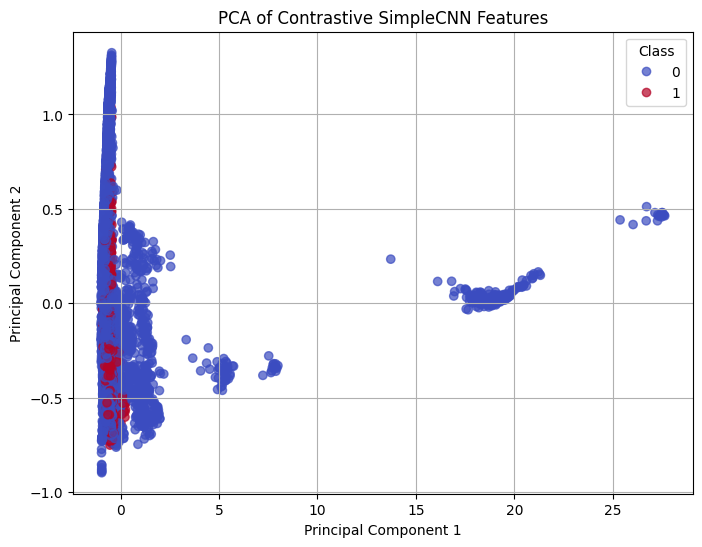

<ipython-input-3-6ce494e2979a>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)


Epoch 1 - Loss: 0.2866
Epoch 2 - Loss: 0.1690
Epoch 3 - Loss: 0.1515
Epoch 4 - Loss: 0.1431
Epoch 5 - Loss: 0.1354
              precision    recall  f1-score   support

           0     0.9574    0.9642    0.9608      5947
           1     0.8212    0.7932    0.8069      1233

    accuracy                         0.9348      7180
   macro avg     0.8893    0.8787    0.8839      7180
weighted avg     0.9340    0.9348    0.9344      7180

ROC AUC: 0.8787
Precision: 0.8212
Recall: 0.7932
F1 Score: 0.8069


In [ ]:
# 1. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 2. Contrastive Pretraining

## 2.1 Contrastive Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return self.transform(img), self.transform(img)

    def __len__(self):
        return len(self.dataset)


## 2.2 Contrastive Transform
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(),
])


## 2.3 Contrastive DataLoader
contrastive_train = ContrastiveDataset(binary_train, contrastive_transform)
contrastive_loader = DataLoader(contrastive_train, batch_size=128, shuffle=True, num_workers=0)


## 2.4 SimpleCNN Encoder
class SimpleCNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1))
        )
        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        features = self.features(x)
        projections = self.projector(features)
        return projections


encoder = SimpleCNNEncoder().to(device)
optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3)


## 2.5 NT-Xent Loss
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)
    labels = torch.cat([torch.arange(z1.size(0)) for _ in range(2)], dim=0).to(device)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    mask = torch.eye(labels.size(0), device=device).bool()
    labels = labels[~mask].view(labels.size(0), -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.size(0), -1)
    positives = similarity_matrix[labels.bool()].view(similarity_matrix.size(0), -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.size(0), -1)
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.size(0), dtype=torch.long).to(device)
    return F.cross_entropy(logits / temperature, labels)


## 2.6 Pretrain the Encoder
for epoch in range(5):
    encoder.train()
    running_loss = 0.0
    for img1, img2 in contrastive_loader:
        img1, img2 = img1.to(device), img2.to(device)
        z1, z2 = encoder(img1), encoder(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer_enc.zero_grad()
        loss.backward()
        optimizer_enc.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(contrastive_loader):.4f}")


# 3. Feature Extraction and PCA

## 3.1 Feature Extraction
def extract_features(encoder, loader):
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            feat = encoder.features(imgs)
            feat = F.adaptive_avg_pool2d(feat, (1, 1)).view(feat.size(0), -1)
            features.append(feat.cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.concatenate(labels)


feature_loader = DataLoader(binary_test, batch_size=64, shuffle=False, num_workers=0)
test_features, test_labels = extract_features(encoder, feature_loader)


## 3.2 PCA Visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=test_labels, cmap='coolwarm', alpha=0.7)
plt.title('PCA of Contrastive SimpleCNN Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class")
plt.grid(True)
plt.show()


# 4. Downstream Fine-Tuning

## 4.1 Downstream Classifier
class DownstreamClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.backbone = encoder.features
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.classifier(x)
        return x


model_downstream = DownstreamClassifier(encoder).to(device)
optimizer_downstream = torch.optim.Adam(model_downstream.parameters(), lr=1e-4)
criterion_downstream = nn.CrossEntropyLoss()


## 4.2 Fine-Tuning
def train_downstream(model, loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(loader):.4f}")


train_downstream(model_downstream, train_loader, optimizer_downstream, criterion_downstream, epochs=5)


## 4.3 Evaluation
def evaluate_downstream(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1).cpu().numpy()
            y_true.append(labels.numpy())
            y_pred.append(preds)
    return np.concatenate(y_true), np.concatenate(y_pred)


y_true, y_pred = evaluate_downstream(model_downstream, test_loader)
print(classification_report(y_true, y_pred, digits=4))
print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")


Next is the exercise.ipynb
this is what you will be assesed on.

